<div style="background-color: lightblue; padding: 10px; border-radius: 5px;">

## QSAR-based prediction of molecular solubility using Molecular Fingerprints and vanilla regressors.

**Goal** Train and evaluate a regressor (e.g., LinearRegression, RandomForest, XGBoost) to predict solubility of a given molecule. The input is given by a set of physicochemical descriptors or/and the fingerprints representing such modecule.
</div>


<div style="background-color: lightblue; padding: 10px; border-radius: 5px;">

**Training dataset** : **ESOL** dataset
* ~1,100 molecules represented by SMILES strings [note that SMILES rep can be used to compute many other features]
* a number of physico-chemical features pre-computed for each molecule

</div>

<div style="background-color: lightblue; padding: 10px; border-radius: 5px;">

**Tools**
* `scikit-learn` and `pandas`
* **Core cheminfo**: `RDKit` **smiles, descriptors, fingerprints** to automate molecular representation and generate the input to the classifier
* **models**: LinearRegression, RandomForest, XGBoost regressor, PCA; the optimized XGBoost model is saved to file usign `joblib`
* **evaluation/interpretation metrics**: RMSE, R2, feature importance, both built-in and **permutation**

</div>

In [4]:
import pandas as pd                            # per caricare e manipolare i dati
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt            

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs

import joblib
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor

from sklearn.decomposition import PCA

# Set global font sizes across the notebook
mpl.rcParams['axes.titlesize'] = 16       # Title font size
mpl.rcParams['axes.labelsize'] = 16       # Axis label font size
mpl.rcParams['xtick.labelsize'] = 14      # X-axis tick label font size
mpl.rcParams['ytick.labelsize'] = 14      # Y-axis tick label font size
mpl.rcParams['legend.fontsize'] = 16      # Legend font size
#mpl.rcParams['figure.titlesize'] = 16     # Figure title size


# Helper functions: Compute RDKit descriptors
def compute_descriptors(mol):
    
    """ Helper function: compute descriptors from mol object, as from SMILES representation 
        There are human-readable, interpretable and carry physicochemical information

        INPUT: mol (RDKit representation), molecular representation from parsed SMILES string
        OUTPUT: desc, dictionary of physico-chemical properties and their values
    """
 
    desc = {}
    desc['MolWt'] = Descriptors.MolWt(mol)        # here we know the "Descriptors" functions commands explicitly
    desc['LogP'] = Descriptors.MolLogP(mol)
    desc['NumHDonors'] = Descriptors.NumHDonors(mol)
    desc['NumHAcceptors'] = Descriptors.NumHAcceptors(mol)
    desc['TPSA'] = Descriptors.TPSA(mol)
    desc['NumRotatableBonds'] = Descriptors.NumRotatableBonds(mol)
    
    return desc

# Compute ECFP4 fingerprint (bit vector), Morgan fingerptins with a radius of 2
def compute_ecfp4(mol, nBits=2048):
    
    """ Compute 2048 bit fingerprints out of mol
        These are not human readable, not easily interpretable; but capture struturals subgraphs info

        INPUT: mol (RDKit representation), molecular representation from parsed SMILES string
        OUTPUT: arr, binary array of size 2048 with the fingerprint representation
    """
    
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=nBits)
    arr = np.zeros((1,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# featurizer: prepare features for the regression
def featurizer(smiles_list):
    
    """ Take in list of SMILES representation for different molecules, and return Chem descriptors &
        Fingerprints representations
    
        OUTPUT: * features (dict), dictionary of features 
                * valid_feature_idx (list), list of indexes of molecules that are legit (not Nan!)
    """
    
    features = []
    valid_feature_idx = []
    
    for i, smi in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smi)
        if mol:
            desc = compute_descriptors(mol)   # this is a dictionary already
            fp = compute_ecfp4(mol)
            desc.update({f'ECFP_{j}': fp[j] for j in range(len(fp))})   # add fingerprint dictionary entries
            features.append(desc)
            valid_feature_idx.append(i)
        else:
            print(f"Invalid SMILES skipped: {smi}")
    return features, valid_feature_idx

# hyperparameter optimization
def grid_search(model, param_grid):

    """ Run grid search on model hyper-parameters to identify the best model, return the best model object
    
        INPUT: model, estimator object (for instance a scikit-learn object)
            param_grid, dictionary of the model hyperparameters we would like to tune
        OUTPUT: best model out of all screened ones (according to cv)
    """
    
    print('Running ' + str(model) + ' for fitting...')
    # Grid search with 5-fold cross-validation: this is built-in in scikit-learn
    grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,   # dictionary
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,
                           verbose=1)
    # Fit the model
    grid_search.fit(X_train, y_train)

    print(f"Best n_estimators: {grid_search.best_params_['n_estimators']}")
    print(f"Best cross-validated RMSE: {-grid_search.best_score_:.3f}")

    # extract best estimator/best model out of those tested
    return grid_search.best_estimator_

def model_test(best_model, X, y, X_test, y_test, plot_title):
    
    """ Test model on test set, compare with measured data, run cross validatin as ultimate metric 
        INPUT: * best_model, estimator
               * X/X_test (np.array, n-samples x n_features): full/test dataset
               * y/y_test (np.array, n_samples): full output
               * plot_title (str): title to use in the plot
        OUTPUT: scatterplot prediction v measured y
    """
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"Test RMSE: {rmse:.3f}")
    print(f"Test R²: {r2:.3f}")
    print('-----')
    # run cross validation on the full dataset
    scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_root_mean_squared_error') 
    print("Cross-Validation RMSE scores:", -scores)  # negate because sklearn returns negative RMSE
    print("Mean RMSE: {:.3f} ± {:.3f}".format(-scores.mean(), scores.std()))

    # Plot predicted vs actual
    plt.figure(figsize=(6,6))
    plt.scatter(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.annotate(f'RMSE: {rmse:.3f}', xy =(-2,-8), fontsize = 16)
    plt.annotate(f'$R^2$: {r2:.3f}', xy =(-2,-9), fontsize = 16)
    plt.xlabel('Measured Solubility')
    plt.ylabel('Predicted Solubility')
    plt.title(plot_title)
    plt.show()

# Load ESOL dataset
# Option 1: via DeepChem (if installed)
try:
    import deepchem as dc
    tasks, datasets, transformers = dc.molnet.load_esol(featurizer='Raw')
    dataset = datasets['train'] + datasets['valid'] + datasets['test']
    smiles_list = [x.smiles for x in dataset]
    y = dataset.y.flatten()
except ImportError:
    print("DeepChem not installed, loading ESOL CSV directly.")
    url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv"
    df = pd.read_csv(url)
    smiles_list = df['smiles'].values   #list of smiles representations for the molecules in the dataset
    y = df['measured log solubility in mols per litre'].values   # target we want to do regression on



DeepChem not installed, loading ESOL CSV directly.


In [5]:
### select regressor and parameters here
regressors = {"RandomForest": RandomForestRegressor(random_state=42),
              "XGBoost": XGBRegressor(random_state=42, verbosity=0),
             "LinearRegression": LinearRegression()}

param_grid = {"RandomForest": {'n_estimators': [10,25,50,100,200,300]},
             "XGBoost": {'n_estimators': [100, 300],
                         'max_depth': [5, 10, None],
                         'min_samples_split': [2, 5],
                         'min_samples_leaf': [1, 3],
                         'max_features': ['sqrt', 'log2'],
                         },
             "LinearRegression": None}

In [6]:
regres_model = "XGBoost"

<div style="background-color: lightgreen; padding: 10px; border-radius: 5px;">

#### Featurization, prepare X and y for the regression

</div>

In [7]:
# Prepare features dataframe: appending descriptors & fingerprints, all together; both continuous and discrete vars
features, valid_idx = featurizer(smiles_list)
    
# convert to pd Dataframe: features is a list of dictionaries: to preseve column identity and labels
X = pd.DataFrame(features)
feature_names = list(X.columns)

y = y[valid_idx]   # important to only retain legit/valid molecules

print('Number of samples, molecules in database = ' + str(X.shape[0]))
print('Number of valid molecules = ' + str(len(valid_idx)))
print('Number of total features (both dscriptors and fingerprints) = ' + str(X.shape[1]))

[21:24:11] DEPRECATION WARNING: please use MorganGenerator
[21:24:11] DEPRECATION WARNING: please use MorganGenerator
[21:24:11] DEPRECATION WARNING: please use MorganGenerator
[21:24:11] DEPRECATION WARNING: please use MorganGenerator
[21:24:11] DEPRECATION WARNING: please use MorganGenerator
[21:24:11] DEPRECATION WARNING: please use MorganGenerator
[21:24:11] DEPRECATION WARNING: please use MorganGenerator
[21:24:11] DEPRECATION WARNING: please use MorganGenerator
[21:24:11] DEPRECATION WARNING: please use MorganGenerator
[21:24:11] DEPRECATION WARNING: please use MorganGenerator
[21:24:11] DEPRECATION WARNING: please use MorganGenerator
[21:24:11] DEPRECATION WARNING: please use MorganGenerator
[21:24:11] DEPRECATION WARNING: please use MorganGenerator
[21:24:11] DEPRECATION WARNING: please use MorganGenerator
[21:24:11] DEPRECATION WARNING: please use MorganGenerator
[21:24:11] DEPRECATION WARNING: please use MorganGenerator
[21:24:11] DEPRECATION WARNING: please use MorganGenerat

Number of samples, molecules in database = 1128
Number of valid molecules = 1128
Number of total features (both dscriptors and fingerprints) = 2054


<div style="background-color: lightgreen; padding: 10px; border-radius: 5px;">
### Optimize regressor and make predictions
</div>

Use GridSearchCV for selecting best estimator out of CV, span hyperparameter space
Running XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...) for fitting...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best n_estimators: 100
Best cross-validated RMSE: 0.678
Test RMSE: 0.747
Test R²: 

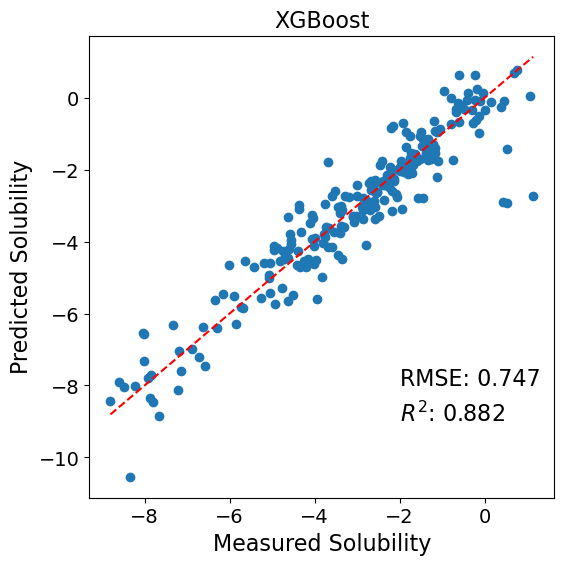

NameError: name 'model' is not defined

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)   # note that we are using a dataframe here, whcih is compatible with the regressor
print('Use GridSearchCV for selecting best estimator out of CV, span hyperparameter space')

# run hyperparameter validation
best_model = grid_search(regressors[regres_model], param_grid[regres_model])
# test and plot
model_test(best_model, X, y, X_test, y_test, regres_model)

# Save the model
joblib.dump(best_model, "./xgb_model_logS.joblib")

<div style="background-color: lightgreen; padding: 10px; border-radius: 5px;">

#### Analyze importance features

</div>

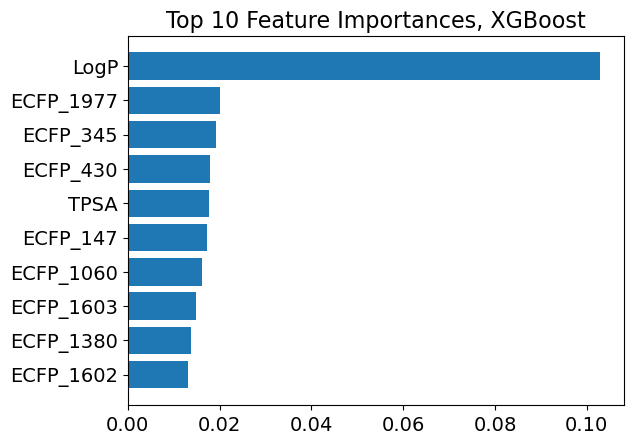

In [10]:
if regres_model == 'xgb':

    # compute the features
    importance = model.get_booster().get_score(importance_type='gain')
    importance_df = pd.DataFrame({
        'Feature': list(importance.keys()),
        'Importance': list(importance.values())
    }).sort_values(by='Importance', ascending=False)

    # produce a plot
    xgb.plot_importance(model, max_num_features=10, importance_type='gain', height=0.5)    # this is built-in for tree-regressors
    plt.title("Top 20 Feature Importances (XGBoost)")
    plt.show()
    
else:
    
    # Estrai importanza feature
    importances = best_model.feature_importances_
    feature_names = X.columns

    # Crea DataFrame importanze ordinato, sort according to importance value
    feat_imp_df = pd.DataFrame({
        'feat': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False)   # sort DataFrame accorsing to importance value

    # Seleziona top 10 feature
    top_features = feat_imp_df['feat'].head(10).tolist()
    importances  = feat_imp_df['importance'].head(10).tolist()
    
    # plot horizontal bar plot
    plt.barh([9,8,7,6,5,4,3,2,1,0], importances, align = 'center')
    plt.yticks([9,8,7,6,5,4,3,2,1,0], top_features)
    
    plt.title("Top 10 Feature Importances, " + regres_model)

### **permutation invariance**: model-agnostic feature importance calculation

In [11]:
# permutation importance for model-agnostic importance
top_n = 10
print('Only showing the most significant ' + str(top_n) + ' features' )

# results is an object with many attributes
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[-top_n:] 
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

Only showing the most significant 10 features


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1047de060>>
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



### Compare performance of "only fingerprints" v "only descriptors" features only

In [ ]:
# test performance with only descriptors

# Set up the parameter grid
param_grid = {
    'n_estimators': [10, 25, 50, 100, 200, 300]
}

# Define the model
model = RandomForestRegressor(random_state=42)
    
# Separate fingerprints from descriptors
fp_cols = [col for col in X.columns if col.startswith('ECFP_')]
desc_cols = [col for col in X.columns if not col.startswith('ECFP_')]

X_fp = X[fp_cols]
X_desc = X[desc_cols]

setup = {"desc" : X_desc, "fp" : X_fp}

for key, X_ in setup.items():
    print('Focusing on ' + key + ' approach')
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_, y, test_size=0.2, random_state=42)   # note that we are using a dataframe here, whcih is compatible with the regressor
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    print('Use GridSearchCV for selecting best estimator out of CV, span hyperparameter space')
    # run hyperparameter validation
    best_model = grid_search(model, param_grid)
    # test and plot
    model_test(best_model, X_, y, X_test, y_test, 'RF_only' + key)

In [ ]:
# fingerprints are highly dimensionaly quantity...maybe we can use dimensionality reduction there, like PCA to reduce
# the dimensionality of the dataset, and see what happens

In [ ]:

# Separate fingerprints from descriptors
fp_cols = [col for col in X.columns if col.startswith('ECFP_')]
desc_cols = [col for col in X.columns if not col.startswith('ECFP_')]

X_fp = X[fp_cols]
X_desc = X[desc_cols]

# Apply PCA to fingerprints, we can only run PCA on high dimensional data
pca = PCA(n_components=20)  # try 20–100 components
X_fp_pca = pca.fit_transform(X_fp)

# RE-Combine PCA-reduced fingerprints with descriptors
X_reduced = np.hstack((X_desc.values, X_fp_pca))
print("Reduced shape:", X_reduced.shape)

In [ ]:
#X_red = pd.DataFrame(X_reduced)  # here we have no dictonary to preserve, so array or DataFrame is equivalent
#print(X_red.head())

In [ ]:
# Train-test split: use array X instead of DataFrame
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=200, random_state=42)
#rf = xgb.XGBRegressor(n_estimators=200, random_state=42, verbosity=0)

rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R^2: {r2:.3f}")

# Plot predicted vs actual
plt.figure(figsize=(6,6))
plt.plot(y_test, y_pred, 'o')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Measured Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Random Forest Regression - ESOL Dataset')
plt.show()

In [ ]:
# input/output can be saved to csv (if portability, readability in GitHub/excel) or pickle (if keeping everything internal to the python pipelien)